In [1]:
from fastai.vision.all import *
from moving_mnist.models.seq2seq import *
from moving_mnist.models.conv_rnn import StackUnstack, StackLoss, MultiImageDice
from moving_mnist.data import *

In [2]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
    print(torch.cuda.get_device_name())

Quadro RTX 8000


# Train Example:

We wil predict:
- `n_in`: 5 images
- `n_out`: 5 images  
- `n_obj`: up to 3 objects

In [3]:
Path.cwd()

Path('/home/tcapelle/SteadySun/moving_mnist')

In [4]:
DATA_PATH = Path.cwd()/'data'

In [5]:
ds = MovingMNIST(DATA_PATH, n_in=5, n_out=5, n_obj=[1,2], th=0.7)

In [6]:
train_tl = TfmdLists(range(7500), ImageTupleTransform(ds))
valid_tl = TfmdLists(range(100), ImageTupleTransform(ds))

In [7]:
dls = DataLoaders.from_dsets(train_tl, valid_tl, bs=64,
                             after_batch=[Normalize.from_stats(*mnist_stats)]).cuda()

In [8]:
mse_loss = StackLoss(MSELossFlat(axis=1))
metrics = []

Left: Input, Right: Target

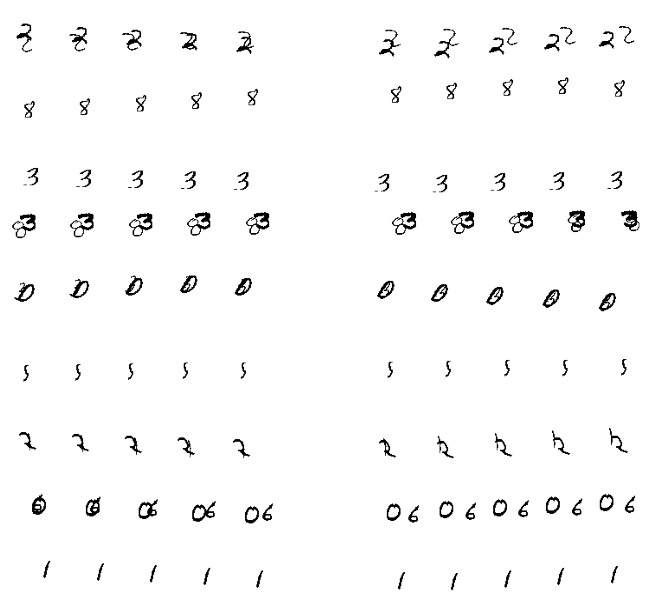

In [9]:
dls.show_batch()

## Baseline

`StackUnstack` takes cares of stacking the list of images into a fat tensor, and unstacking them at the end, we will need to modify our loss function to take a list of tensors as input and target.

In [14]:
model = StackUnstack(Seq2Seq(5, ch_out=1), dim=1).cuda()

As the `ImageSeq` is a `tuple` of images, we will need to stack them to compute loss.

In [15]:
learn = Learner(dls, model, loss_func=mse_loss, metrics=metrics, cbs=[Encoderloss(mse_loss)])

I have a weird bug that if I use `nn.LeakyReLU` after doing `learn.lr_find()` the model does not train (the loss get stucked).

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.0002290867705596611)

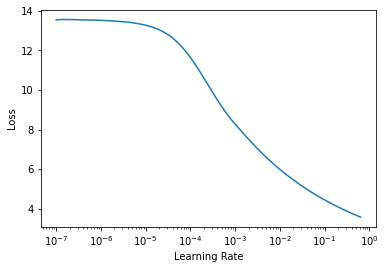

In [16]:
learn.lr_find()

In [17]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,time
0,0.968390,0.475250,00:17
1,0.458564,0.382889,00:17
2,0.384596,0.382675,00:17
3,0.362565,0.364729,00:17
4,0.350058,0.340872,00:17
5,0.342529,0.370137,00:17
6,0.338300,0.323565,00:17
7,0.330416,0.337744,00:17
8,0.331589,0.330797,00:17
9,0.329548,0.300523,00:17


In [18]:
p,t = learn.get_preds()

As you can see, the results is a list of 5 tensors with 100 samples each.

In [19]:
len(p), p[0].shape

(5, torch.Size([100, 1, 64, 64]))

In [20]:
def show_res(t, idx, argmax=False):
    if argmax:
        im_seq = ImageSeq.create([t[i][idx].argmax(0).unsqueeze(0) for i in range(5)], TensorMask)
    else:
        im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

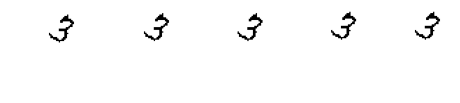

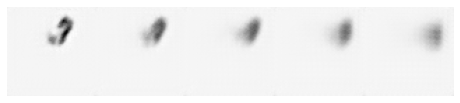

In [21]:
k = random.randint(0,99)
show_res(t,k)
show_res(p,k, False)

## Teacher Forcing

In [35]:
model = StackUnstack(Seq2Seq(5, ch_out=1, ks=5, n_layers=2, debug=False), dim=1).cuda()

In [36]:
learn = Learner(dls, model, loss_func=mse_loss, metrics=metrics, cbs=[TeacherForcing(4), Encoderloss(mse_loss, alpha=1)])

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.0002290867705596611)

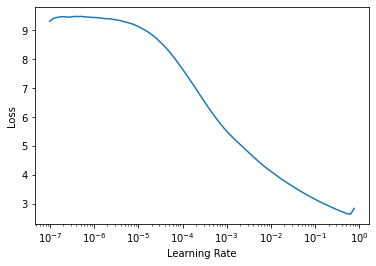

In [37]:
learn.lr_find()

In [38]:
learn.fit_one_cycle(12, 1e-3)

epoch,train_loss,valid_loss,time
0,0.918584,0.692072,00:24
1,0.539968,0.473838,00:24
2,0.460702,0.443463,00:24
3,0.436489,0.404378,00:24
4,0.420070,0.414767,00:24
5,0.401452,0.403163,00:24
6,0.387216,0.374451,00:24
7,0.370222,0.354994,00:24
8,0.358856,0.358411,00:24
9,0.348909,0.343605,00:24


In [39]:
p,t = learn.get_preds()

As you can see, the results is a list of 5 tensors with 100 samples each.

In [40]:
len(p), p[0].shape

(5, torch.Size([100, 1, 64, 64]))

In [41]:
def show_res(t, idx, argmax=False):
    if argmax:
        im_seq = ImageSeq.create([t[i][idx].argmax(0).unsqueeze(0) for i in range(5)], TensorMask)
    else:
        im_seq = ImageSeq.create([t[i][idx] for i in range(5)])
    im_seq.show(figsize=(8,4));

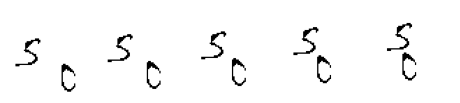

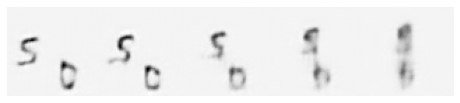

In [42]:
k = random.randint(0,99)
show_res(t,k)
show_res(p,k, False)